## Modeling Gold Prices: Summary of the model runs below

###Models: Group A
Modeling next days gold price directly
1. 




In [72]:
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import time
import scipy.stats as stats

import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

import statsmodels.api as sm

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 5]

In [3]:
GP_df = pd.read_csv('../Data/final_Data_for_Modeling.csv', parse_dates=['Date'])

In [4]:
GP_df

Unnamed: 0       Date     Gold   Silver  Platinum  Palladium  \
0              0 2000-01-04   282.05   5.3025     442.0      444.0   
1              1 2000-01-05   282.10   5.2850     438.0      438.0   
2              2 2000-01-06   280.35   5.1400     420.0      435.0   
3              3 2000-01-07   282.10   5.1350     418.0      438.0   
4              4 2000-01-10   281.70   5.1450     418.0      449.0   
...          ...        ...      ...      ...       ...        ...   
4858        4972 2019-09-26  1507.05  17.9700     932.0     1663.0   
4859        4973 2019-09-27  1496.15  17.5200     929.0     1670.0   
4860        4974 2019-09-30  1487.60  17.2550     925.0     1691.0   
4861        4975 2019-10-01  1473.45  17.1100     881.0     1667.0   
4862        4976 2019-10-02  1492.60  17.2600     879.0     1676.0   

            SP500           DJI     FTSE  TBill  FedFundRates     USDX  \
0     1399.420044  10997.929688  6665.86   6.49          5.38  100.100   
1     1402.109985  11122.650391  6535.90   6.62          5.41  100.050   
2     1403.449951  11253.259766  6447.24   6.57          5.54  100.340   
3     1441.469971  11522.559570  6504.75   6.52          5.61  100.500   
4     1457.599976  11572.200195  6607.71   6.57          5.74  100.650   
...           ...           ...      ...    ...           ...      ...   
4858  2977.620117  26891.119141  7351.08   1.70          1.85   98.765   
4859  2961.790039  26820.250000  7426.21   1.69          1.83   98.761   
4860  2976.739990  26916.830078  7408.21   1.68          1.90   99.021   
4861  2940.250000  26573.039063  7408.21   1.68          1.90   98.777   
4862  2887.610107  26078.619141  7408.21   1.68          1.90   98.689   

      GoldFutures  OilSpot  
0           282.7    25.56  
1           281.1    24.65  
2           281.4    24.79  
3           281.9    24.79  
4           281.7    24.71  
...           ...      ...  
4858       1511.6    56.24  
4859       1511.6    55.95  
4860       1511.6    54.09  
4861       1511.6    54.09  
4862       1511.6    54.09  

[4863 rows x 14 columns]

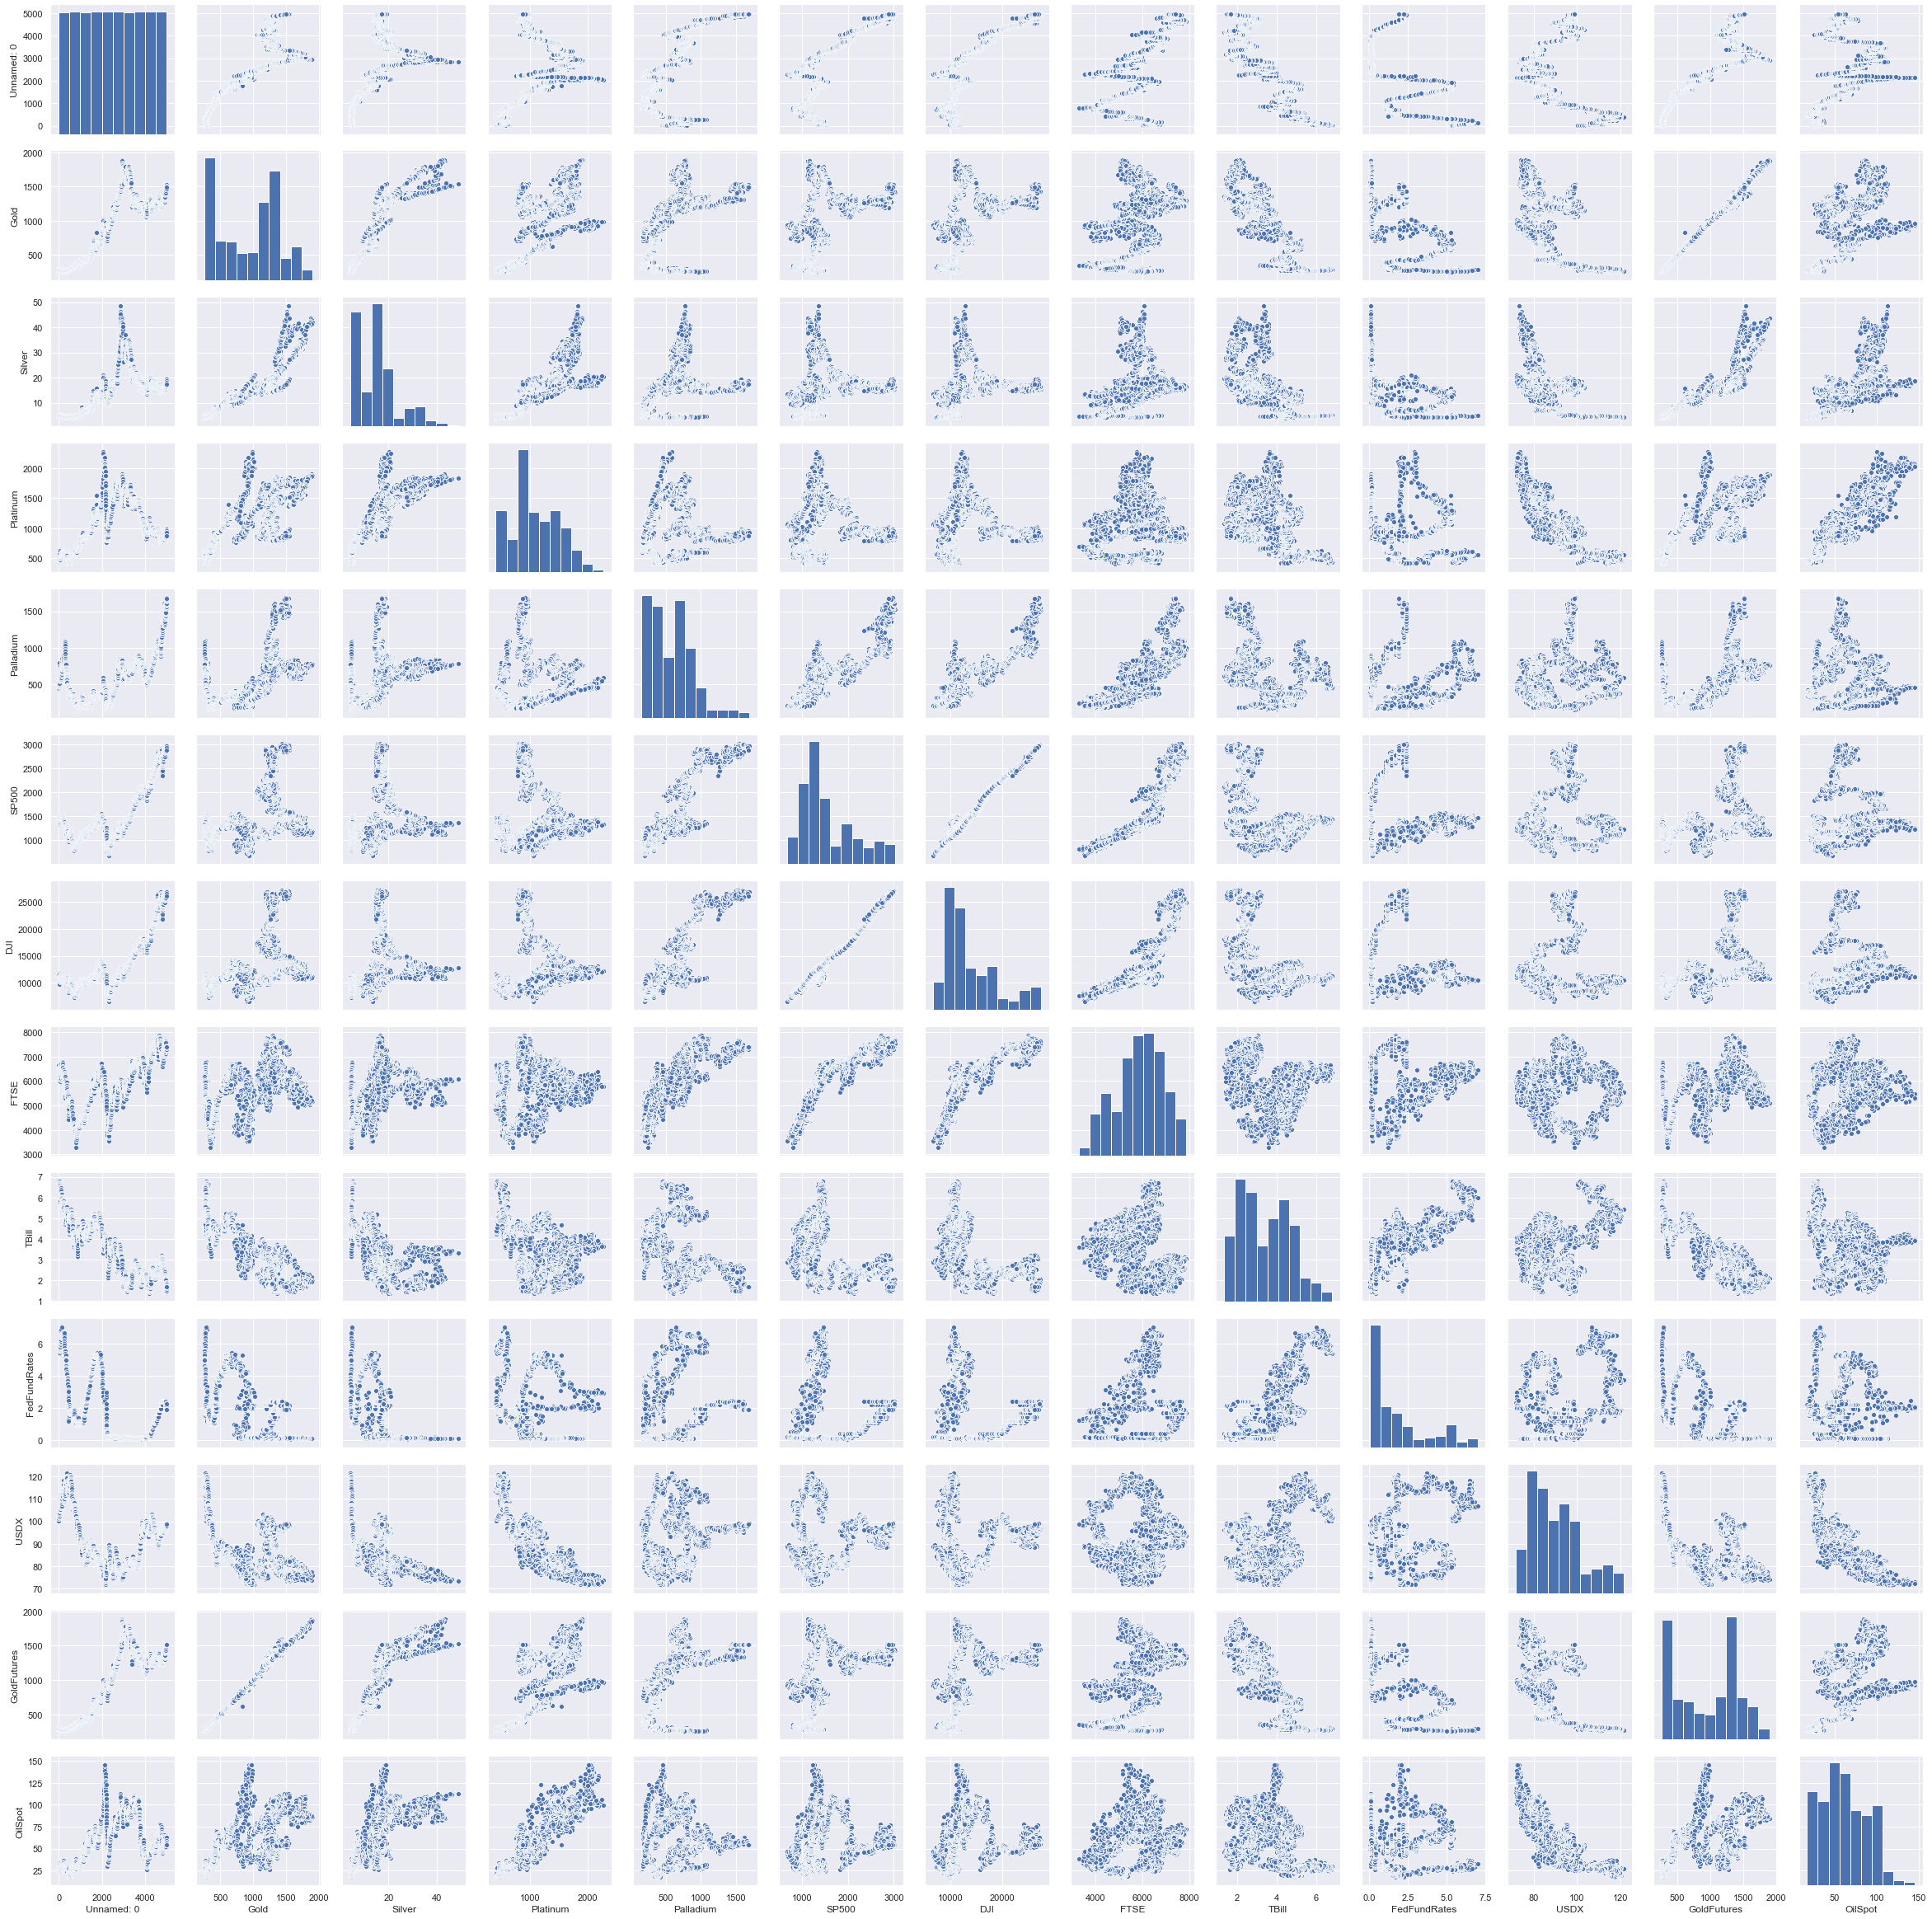

In [16]:
sns.pairplot(GP_df)

In [25]:
GP_df['Gold_next'] = GP_df['Gold'].shift(periods=-1)
GP_df['GPInc'] = (GP_df['Gold_next']/GP_df['Gold']-1)
GP_df["year"]=pd.to_datetime(GP_df['Date'], format='%Y-%m-%d').dt.year - 2000
GP_df

Unnamed: 0       Date     Gold   Silver  Platinum  Palladium  \
0              0 2000-01-04   282.05   5.3025     442.0      444.0   
1              1 2000-01-05   282.10   5.2850     438.0      438.0   
2              2 2000-01-06   280.35   5.1400     420.0      435.0   
3              3 2000-01-07   282.10   5.1350     418.0      438.0   
4              4 2000-01-10   281.70   5.1450     418.0      449.0   
...          ...        ...      ...      ...       ...        ...   
4858        4972 2019-09-26  1507.05  17.9700     932.0     1663.0   
4859        4973 2019-09-27  1496.15  17.5200     929.0     1670.0   
4860        4974 2019-09-30  1487.60  17.2550     925.0     1691.0   
4861        4975 2019-10-01  1473.45  17.1100     881.0     1667.0   
4862        4976 2019-10-02  1492.60  17.2600     879.0     1676.0   

            SP500           DJI     FTSE  TBill  FedFundRates     USDX  \
0     1399.420044  10997.929688  6665.86   6.49          5.38  100.100   
1     1402.109985  11122.650391  6535.90   6.62          5.41  100.050   
2     1403.449951  11253.259766  6447.24   6.57          5.54  100.340   
3     1441.469971  11522.559570  6504.75   6.52          5.61  100.500   
4     1457.599976  11572.200195  6607.71   6.57          5.74  100.650   
...           ...           ...      ...    ...           ...      ...   
4858  2977.620117  26891.119141  7351.08   1.70          1.85   98.765   
4859  2961.790039  26820.250000  7426.21   1.69          1.83   98.761   
4860  2976.739990  26916.830078  7408.21   1.68          1.90   99.021   
4861  2940.250000  26573.039063  7408.21   1.68          1.90   98.777   
4862  2887.610107  26078.619141  7408.21   1.68          1.90   98.689   

      GoldFutures  OilSpot  Gold_next     GPInc  year  
0           282.7    25.56     282.10  0.000177     0  
1           281.1    24.65     280.35 -0.006203     0  
2           281.4    24.79     282.10  0.006242     0  
3           281.9    24.79     281.70 -0.001418     0  
4           281.7    24.71     282.25  0.001952     0  
...           ...      ...        ...       ...   ...  
4858       1511.6    56.24    1496.15 -0.007233    19  
4859       1511.6    55.95    1487.60 -0.005715    19  
4860       1511.6    54.09    1473.45 -0.009512    19  
4861       1511.6    54.09    1492.60  0.012997    19  
4862       1511.6    54.09        NaN       NaN    19  

[4863 rows x 17 columns]

In [26]:
print(GP_df.columns)

Index(['Unnamed: 0', 'Date', 'Gold', 'Silver', 'Platinum', 'Palladium',
       'SP500', 'DJI', 'FTSE', 'TBill', 'FedFundRates', 'USDX', 'GoldFutures',
       'OilSpot', 'Gold_next', 'GPInc', 'year'],
      dtype='object')


In [31]:
train_set_def = GP_df['year']<=15
test_set_def = (GP_df['year']>15) * (GP_df['year']<=18)

variables = ['Gold', 'GoldFutures','Silver', 'Platinum', 'Palladium', 'OilSpot', \
            'SP500', 'DJI', 'FTSE', 'TBill', 'FedFundRates', 'USDX', \
            ]

x_train = GP_df.loc[train_set_def, variables].copy()
y_train = GP_df.loc[train_set_def, 'GPInc'].copy()

x_test = GP_df.loc[test_set_def, variables].copy()
y_test = GP_df.loc[test_set_def, 'GPInc'].copy()

//anaconda3/envs/metis/lib/python3.7/site-packages/pandas/core/computation/expressions.py:194: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


In [64]:
def linear_wCoefs(xt, yt, xval, yval):
    lm = LinearRegression()

    lm.fit(xt, yt)
    # score fit model on validation data
    val_score = lm.score(xval, yval)
    
    # report results
    print('\nValidation R^2 score was:', val_score)
    print('Feature coefficient results: \n')
    for feature, coef in zip(xt.columns, lm.coef_):
        print(feature, ':', f'{coef:.8f}')
    
    pred = lm.predict(xval)
    
    xvar1 = xt.columns[0]
    #yvar = yt.columns[0]
    
    plt.subplot(1, 3, 1)
    plt.scatter(xval[xvar1],yval)
    #plt.plot(xval['Gold'], pred, color='blue',linewidth=1)
    plt.title("Regression fit")
    plt.xlabel(xvar1)
    plt.ylabel('y')
    
    plt.subplot(1, 3, 2)
    res = yval - pred
    plt.scatter(pred, res)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")


Validation R^2 score was: -3.3861798881905245
Feature coefficient results: 

Gold : -0.00014197
GoldFutures : 0.00013072
Silver : 0.00057898
Platinum : 0.00000491
Palladium : -0.00001346
OilSpot : -0.00010535
SP500 : -0.00000650
DJI : -0.00000114
FTSE : 0.00000472
TBill : -0.00291041
FedFundRates : 0.00062337
USDX : 0.00006212


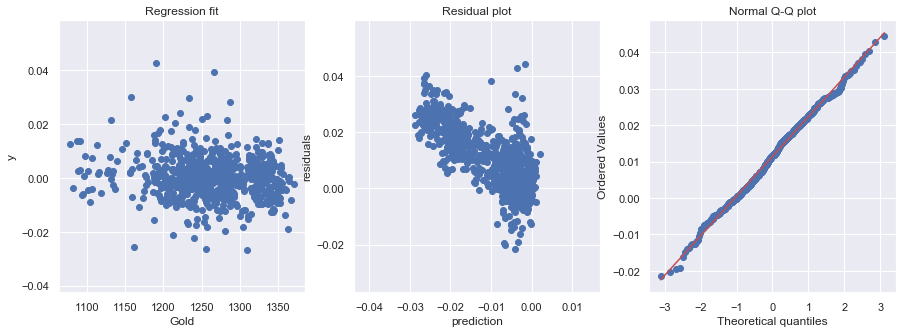

In [65]:
# --- Model 1: Check if %increase has a better forecastability
linear_wCoefs(x_train, y_train, x_test, y_test)


Validation R^2 score was: 0.902440560988262
Feature coefficient results: 

Gold : 0.85070640
GoldFutures : 0.13832982
Silver : 0.57797179
Platinum : 0.00635830
Palladium : -0.01151064
OilSpot : -0.11684408
SP500 : -0.00217919
DJI : -0.00162330
FTSE : 0.00381579
TBill : -2.76029015
FedFundRates : 0.69783082
USDX : 0.05173002


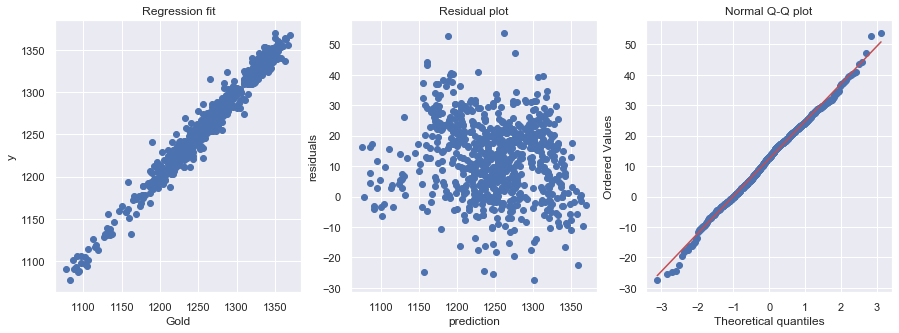

In [66]:
vars2 = ['Gold', 'GoldFutures','Silver', 'Platinum', 'Palladium', 'OilSpot', \
            'SP500', 'DJI', 'FTSE', 'TBill', 'FedFundRates', 'USDX', \
            ]

x_train2 = GP_df.loc[train_set_def, vars2].copy()
y_train2 = GP_df.loc[train_set_def, 'Gold_next'].copy()

x_test2 = GP_df.loc[test_set_def, vars2].copy()
y_test2 = GP_df.loc[test_set_def, 'Gold_next'].copy()

linear_wCoefs(x_train2, y_train2, x_test2, y_test2)


Validation R^2 score was: -29.124731353521536
Feature coefficient results: 

Silver : 25.56313515
Platinum : 0.03713431
Palladium : -0.04461176
OilSpot : 0.44079057
SP500 : 0.28751248
DJI : -0.06695869
FTSE : 0.17078285
TBill : -148.60293861
FedFundRates : -40.60254072
USDX : -1.49336926


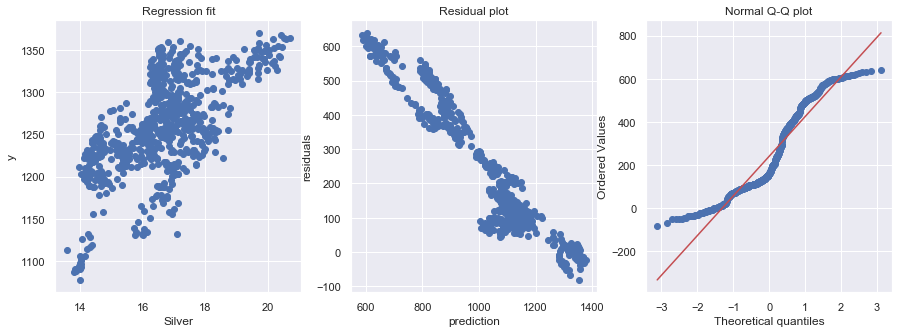

In [67]:
vars3 = ['Silver', 'Platinum', 'Palladium', 'OilSpot', \
            'SP500', 'DJI', 'FTSE', 'TBill', 'FedFundRates', 'USDX', \
            ]

x_train3 = GP_df.loc[train_set_def, vars3].copy()
y_train3 = GP_df.loc[train_set_def, 'Gold_next'].copy()

x_test3 = GP_df.loc[test_set_def, vars3].copy()
y_test3 = GP_df.loc[test_set_def, 'Gold_next'].copy()

linear_wCoefs(x_train3, y_train3, x_test3, y_test3)


Validation R^2 score was: -9.005950241346833
Feature coefficient results: 

Silver : 78.42687766
Platinum : -0.13278170
Palladium : 0.05799546
OilSpot : 0.55845453
SP500 : 0.26332137
DJI : -0.04347515
FTSE : 0.03409972
TBill : -85.87331581
FedFundRates : -23.91683275
USDX : 0.93437692
Silver2 : -0.95607628


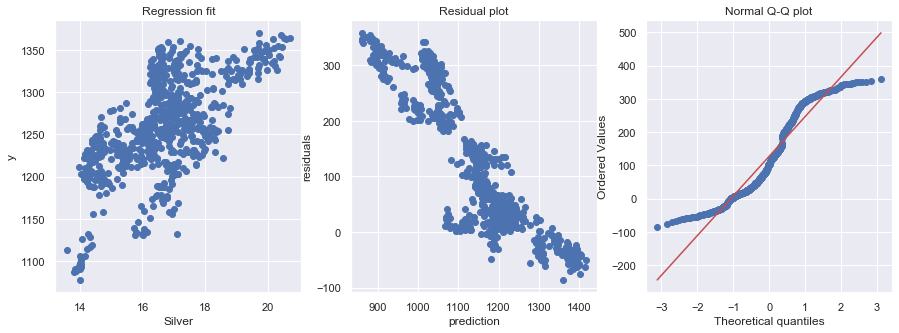

In [68]:
vars3 = ['Silver', 'Platinum', 'Palladium', 'OilSpot', \
            'SP500', 'DJI', 'FTSE', 'TBill', 'FedFundRates', 'USDX', \
            ]

x_train4 = GP_df.loc[train_set_def, vars3].copy()
x_train4['Silver2'] = x_train4['Silver'] ** 2
y_train4 = GP_df.loc[train_set_def, 'Gold_next'].copy()

x_test4 = GP_df.loc[test_set_def, vars3].copy()
x_test4['Silver2'] = x_test3['Silver'] ** 2
y_test4 = GP_df.loc[test_set_def, 'Gold_next'].copy()

linear_wCoefs(x_train4, y_train4, x_test4,  y_test4)


Validation R^2 score was: 0.902440560988262
Feature coefficient results: 

Gold : 0.85070640
GoldFutures : 0.13832982
Silver : 0.57797179
Platinum : 0.00635830
Palladium : -0.01151064
OilSpot : -0.11684408
SP500 : -0.00217919
DJI : -0.00162330
FTSE : 0.00381579
TBill : -2.76029015
FedFundRates : 0.69783082
USDX : 0.05173002


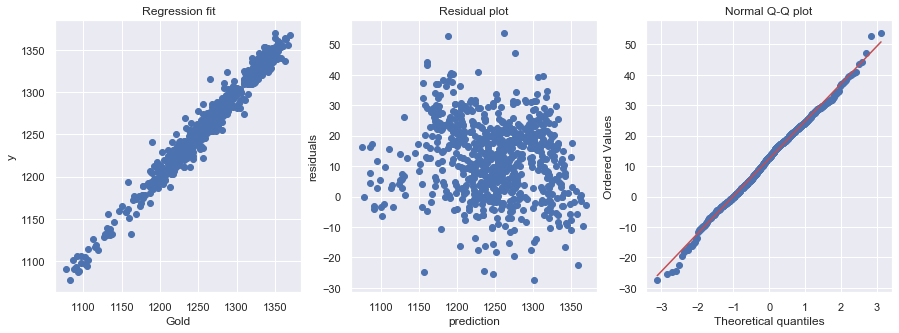

In [76]:
vars2 = ['Gold', 'GoldFutures','Silver', 'Platinum', 'Palladium', 'OilSpot', \
            'SP500', 'DJI', 'FTSE', 'TBill', 'FedFundRates', 'USDX', \
            ]

x_train5 = GP_df.loc[train_set_def, vars2].copy()
#x_train5['Silver2'] = x_train5['Silver'] ** 2
y_train5 = GP_df.loc[train_set_def, 'Gold_next'].copy()

x_test5 = GP_df.loc[test_set_def, vars2].copy()
#x_test5['Silver2'] = x_test5['Silver'] ** 2
y_test5 = GP_df.loc[test_set_def, 'Gold_next'].copy()

linear_wCoefs(x_train5, y_train5, x_test5, y_test5)

In [77]:
model5 = sm.OLS(y_train5, x_train5)
fit5 = model5.fit()
fit5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              Gold_next   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          2.246e+06
Date:                Sat, 05 Oct 2019   Prob (F-statistic):                        0.00
Time:                        21:05:25   Log-Likelihood:                         -15277.
No. Observations:                3934   AIC:                                  3.058e+04
Df Residuals:                    3922   BIC:                                  3.065e+04
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Gold             0.8513      0.009     94.661      0.000       0.834       0.869
GoldFutures      0.1396      0.008     16.467      0.000       0.123       0.156
Silver           0.5627      0.096      5.841      0.000       0.374       0.752
Platinum         0.0077      0.002      4.748      0.000       0.005       0.011
Palladium       -0.0137      0.002     -7.391      0.000      -0.017      -0.010
OilSpot         -0.1123      0.021     -5.478      0.000      -0.153      -0.072
SP500           -0.0022      0.005     -0.445      0.657      -0.012       0.008
DJI             -0.0015      0.001     -2.359      0.018      -0.003      -0.000
FTSE             0.0035      0.001      3.447      0.001       0.002       0.006
TBill           -2.3023      0.548     -4.198      0.000      -3.377      -1.227
FedFundRates     0.7188      0.262      2.739      0.006       0.204       1.233
USDX             0.1241      0.025      4.930      0.000       0.075       0.173
==============================================================================
Omnibus:                     1398.874   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           544636.151
Skew:                          -0.190   Prob(JB):                         0.00
Kurtosis:                      60.641   Cond. No.                     3.98e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.98e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""


Validation R^2 score was: 0.9084946430922861
Feature coefficient results: 

Gold : 0.82971692
GoldFutures : 0.16163575
Silver : 0.55341492
Platinum : 0.00529579
Palladium : -0.01061865
OilSpot : -0.10421200
SP500 : -0.44829536
DJI : -0.00156147
FTSE : 0.00338304
TBill : -3.20765926
FedFundRates : 1.44084632
USDX : 0.04426245
SP2 : 0.00007947
lnSP500 : 294.15139398


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              Gold_next   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.927e+06
Date:                Sat, 05 Oct 2019   Prob (F-statistic):                        0.00
Time:                        21:09:48   Log-Likelihood:                         -15274.
No. Observations:                3934   AIC:                                  3.058e+04
Df Residuals:                    3920   BIC:                                  3.066e+04
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Gold             0.8493      0.009     93.909      0.000       0.832       0.867
GoldFutures      0.1402      0.009     16.282      0.000       0.123       0.157
Silver           0.5419      0.101      5.365      0.000       0.344       0.740
Platinum         0.0068      0.002      3.749      0.000       0.003       0.010
Palladium       -0.0114      0.002     -5.176      0.000      -0.016      -0.007
OilSpot         -0.1248      0.021     -5.807      0.000      -0.167      -0.083
SP500            0.0088      0.012      0.720      0.471      -0.015       0.033
DJI             -0.0018      0.001     -2.791      0.005      -0.003      -0.001
FTSE             0.0034      0.001      3.081      0.002       0.001       0.006
TBill           -2.8840      0.604     -4.775      0.000      -4.068      -1.700
FedFundRates     0.6599      0.264      2.495      0.013       0.141       1.178
USDX             0.0543      0.047      1.162      0.245      -0.037       0.146
SP2          -3.291e-06   3.03e-06     -1.086      0.278   -9.23e-06    2.65e-06
lnSP500          0.9147      1.302      0.702      0.483      -1.639       3.468
==============================================================================
Omnibus:                     1395.411   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           542180.715
Skew:                          -0.178   Prob(JB):                         0.00
Kurtosis:                      60.511   Cond. No.                     1.47e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.47e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

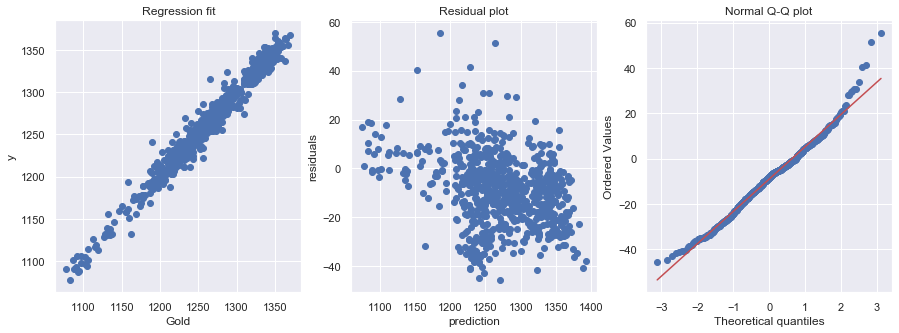

In [80]:
vars2 = ['Gold', 'GoldFutures','Silver', 'Platinum', 'Palladium', 'OilSpot', \
            'SP500', 'DJI', 'FTSE', 'TBill', 'FedFundRates', 'USDX', \
            ]

x_train6 = GP_df.loc[train_set_def, vars2].copy()
x_train6['SP2'] = x_train6['SP500'] ** 2
x_train6['lnSP500'] = np.log(x_train6['SP500'])
y_train6 = GP_df.loc[train_set_def, 'Gold_next'].copy()

x_test6 = GP_df.loc[test_set_def, vars2].copy()
#x_test5['Silver2'] = x_test5['Silver'] ** 2
x_test6['SP2'] = x_test6['SP500'] ** 2
x_test6['lnSP500'] = np.log(x_test6['SP500'])
y_test6 = GP_df.loc[test_set_def, 'Gold_next'].copy()

linear_wCoefs(x_train6, y_train6, x_test6, y_test6)

model6 = sm.OLS(y_train6, x_train6)
fit6 = model6.fit()
fit6.summary()


Validation R^2 score was: 0.8989500797875908
Feature coefficient results: 

Gold : 0.85034073
GoldFutures : 0.13848342
Silver : 0.59075350
Platinum : 0.00656726
Palladium : -0.01185987
OilSpot : -0.11570374
DJI : -0.00187007
FTSE : 0.00374421
TBill : -2.79818007
FedFundRates : 0.67760271
USDX : 0.05662515


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              Gold_next   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          2.451e+06
Date:                Sun, 06 Oct 2019   Prob (F-statistic):                        0.00
Time:                        08:11:01   Log-Likelihood:                         -15277.
No. Observations:                3934   AIC:                                  3.058e+04
Df Residuals:                    3923   BIC:                                  3.065e+04
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Gold             0.8509      0.009     95.048      0.000       0.833       0.868
GoldFutures      0.1397      0.008     16.502      0.000       0.123       0.156
Silver           0.5758      0.092      6.280      0.000       0.396       0.756
Platinum         0.0079      0.002      5.122      0.000       0.005       0.011
Palladium       -0.0141      0.002     -8.442      0.000      -0.017      -0.011
OilSpot         -0.1112      0.020     -5.466      0.000      -0.151      -0.071
DJI             -0.0017      0.000     -6.885      0.000      -0.002      -0.001
FTSE             0.0035      0.001      3.420      0.001       0.001       0.005
TBill           -2.3405      0.542     -4.322      0.000      -3.402      -1.279
FedFundRates     0.6980      0.258      2.703      0.007       0.192       1.204
USDX             0.1293      0.022      5.783      0.000       0.085       0.173
==============================================================================
Omnibus:                     1397.931   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           544887.684
Skew:                          -0.185   Prob(JB):                         0.00
Kurtosis:                      60.654   Cond. No.                     3.91e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.91e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

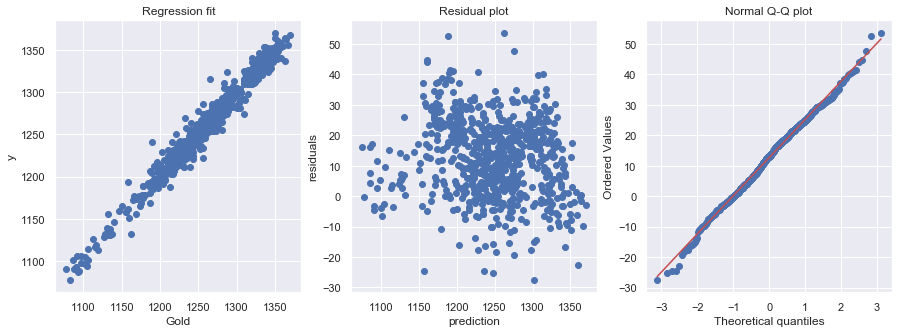

In [82]:
vars3 = ['Gold', 'GoldFutures','Silver', 'Platinum', 'Palladium', 'OilSpot', \
            'DJI', 'FTSE', 'TBill', 'FedFundRates', 'USDX', \
            ]

x_train7 = GP_df.loc[train_set_def, vars3].copy()
#x_train7['SP2'] = x_train7['SP500'] ** 2
#x_train7['lnSP500'] = np.log(x_train7['SP500'])
y_train7 = GP_df.loc[train_set_def, 'Gold_next'].copy()

x_test7 = GP_df.loc[test_set_def, vars3].copy()
#x_test5['Silver2'] = x_test5['Silver'] ** 2
#x_test6['SP2'] = x_test6['SP500'] ** 2
#x_test7['lnSP500'] = np.log(x_test7['SP500'])
y_test7 = GP_df.loc[test_set_def, 'Gold_next'].copy()

linear_wCoefs(x_train7, y_train7, x_test7, y_test7)

model7 = sm.OLS(y_train7, x_train7)
fit7 = model7.fit()
fit7.summary()

In [85]:
GP_df['Gold_1week'] = GP_df['Gold'].shift(periods=-5)
GP_df.head(20)

Unnamed: 0       Date    Gold  Silver  Platinum  Palladium        SP500  \
0            0 2000-01-04  282.05  5.3025     442.0      444.0  1399.420044   
1            1 2000-01-05  282.10  5.2850     438.0      438.0  1402.109985   
2            2 2000-01-06  280.35  5.1400     420.0      435.0  1403.449951   
3            3 2000-01-07  282.10  5.1350     418.0      438.0  1441.469971   
4            4 2000-01-10  281.70  5.1450     418.0      449.0  1457.599976   
5            5 2000-01-11  282.25  5.1550     420.0      450.0  1438.560059   
6            6 2000-01-12  282.25  5.1450     421.0      450.0  1432.250000   
7            7 2000-01-13  282.20  5.0900     423.0      440.5  1449.680054   
8            8 2000-01-14  284.15  5.0950     429.0      439.0  1465.150024   
9           10 2000-01-18  286.85  5.1300     434.0      436.0  1455.140015   
10          11 2000-01-19  288.75  5.1025     444.0      441.0  1455.900024   
11          12 2000-01-20  288.35  5.1300     444.0      445.0  1445.569946   
12          13 2000-01-21  287.75  5.1800     442.0      454.0  1441.359985   
13          14 2000-01-24  287.45  5.2100     455.0      465.0  1401.530029   
14          15 2000-01-25  288.70  5.2375     461.0      476.0  1410.030029   
15          16 2000-01-26  285.90  5.2000     456.0      475.0  1404.089966   
16          17 2000-01-27  286.50  5.2950     462.0      476.0  1398.560059   
17          18 2000-01-28  286.75  5.3700     495.0      488.0  1360.160034   
18          19 2000-01-31  283.30  5.2600     495.0      484.0  1394.459961   
19          20 2000-02-01  283.65  5.2425     493.0      486.0  1409.280029   

             DJI     FTSE  TBill  FedFundRates    USDX  GoldFutures  OilSpot  \
0   10997.929688  6665.86   6.49          5.38  100.10        282.7    25.56   
1   11122.650391  6535.90   6.62          5.41  100.05        281.1    24.65   
2   11253.259766  6447.24   6.57          5.54  100.34        281.4    24.79   
3   11522.559570  6504.75   6.52          5.61  100.50        281.9    24.79   
4   11572.200195  6607.71   6.57          5.74  100.65        281.7    24.71   
5   11511.080078  6518.94   6.67          5.63  100.26        283.4    25.69   
6   11551.099609  6532.84   6.72          5.59  100.33        282.7    26.30   
7   11582.429688  6531.46   6.63          5.58  100.35        284.1    26.63   
8   11722.980469  6658.18   6.69          5.56  101.45        283.9    28.01   
9   11560.719727  6504.57   6.75          5.83  101.65        288.6    28.98   
10  11489.360352  6445.45   6.73          5.47  101.46        289.8    29.11   
11  11351.299805  6348.73   6.79          5.44  101.15        288.8    29.67   
12  11251.709961  6346.31   6.79          5.36  101.51        289.3    29.71   
13  11008.169922  6379.83   6.69          5.53  101.96        287.7    29.25   
14  11029.889648  6274.10   6.70          5.46  102.15        286.3    30.28   
15  11032.990234  6375.60   6.69          5.52  102.26        286.3    27.66   
16  11028.019531  6440.97   6.68          5.61  103.03        287.1    27.22   
17  10738.870117  6375.61   6.66          5.58  104.34        283.0    27.27   
18  10940.530273  6268.54   6.68          5.87  104.97        283.2    27.65   
19  11041.049805  6290.93   6.62          5.79  104.77        282.5    28.28   

    Gold_next     GPInc  year  Gold_1week  
0      282.10  0.000177     0      282.25  
1      280.35 -0.006203     0      282.25  
2      282.10  0.006242     0      282.20  
3      281.70 -0.001418     0      284.15  
4      282.25  0.001952     0      286.85  
5      282.25  0.000000     0      288.75  
6      282.20 -0.000177     0      288.35  
7      284.15  0.006910     0      287.75  
8      286.85  0.009502     0      287.45  
9      288.75  0.006624     0      288.70  
10     288.35 -0.001385     0      285.90  
11     287.75 -0.002081     0      286.50  
12     287.45 -0.001043     0      286.75  
13     288.70  0.004349     0      283.30  
14 


Validation R^2 score was: 0.384222383751324
Feature coefficient results: 

Gold : 0.79740307
GoldFutures : 0.16256150
Silver : 1.34039519
Platinum : 0.00635359
Palladium : -0.02419446
OilSpot : -0.20653482
DJI : -0.00527671
FTSE : 0.01808265
TBill : -7.06838925
FedFundRates : -1.92355276
USDX : -0.14922835


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             Gold_1week   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          5.336e+05
Date:                Sun, 06 Oct 2019   Prob (F-statistic):                        0.00
Time:                        08:46:57   Log-Likelihood:                         -18277.
No. Observations:                3934   AIC:                                  3.658e+04
Df Residuals:                    3923   BIC:                                  3.665e+04
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Gold             0.7993      0.019     41.650      0.000       0.762       0.837
GoldFutures      0.1669      0.018      9.193      0.000       0.131       0.202
Silver           1.2884      0.197      6.555      0.000       0.903       1.674
Platinum         0.0109      0.003      3.314      0.001       0.004       0.017
Palladium       -0.0320      0.004     -8.934      0.000      -0.039      -0.025
OilSpot         -0.1907      0.044     -4.375      0.000      -0.276      -0.105
DJI             -0.0048      0.001     -8.881      0.000      -0.006      -0.004
FTSE             0.0171      0.002      7.886      0.000       0.013       0.021
TBill           -5.4767      1.161     -4.717      0.000      -7.753      -3.201
FedFundRates    -1.8526      0.554     -3.346      0.001      -2.938      -0.767
USDX             0.1034      0.048      2.157      0.031       0.009       0.197
==============================================================================
Omnibus:                      764.899   Durbin-Watson:                   0.439
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10614.037
Skew:                          -0.518   Prob(JB):                         0.00
Kurtosis:                      10.980   Cond. No.                     3.91e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.91e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

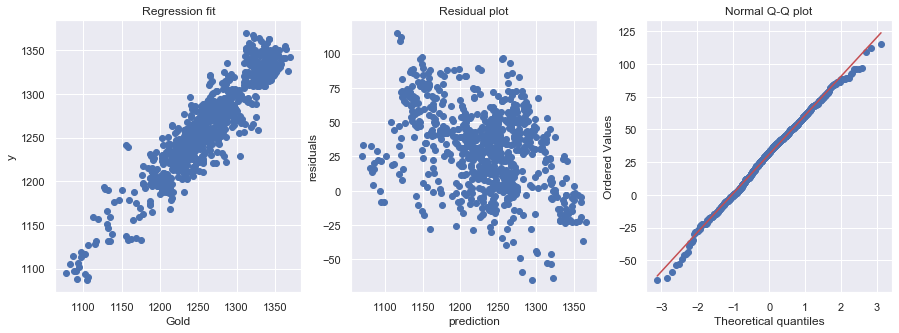

In [114]:
vars3 = ['Gold', 'GoldFutures','Silver', 'Platinum', 'Palladium', 'OilSpot', \
            'DJI', 'FTSE', 'TBill', 'FedFundRates', 'USDX', \
            ]

x_train8 = GP_df.loc[train_set_def, vars3].copy()
y_train8 = GP_df.loc[train_set_def, 'Gold_1week'].copy()

x_test8 = GP_df.loc[test_set_def, vars3].copy()
y_test8 = GP_df.loc[test_set_def, 'Gold_1week'].copy()

linear_wCoefs(x_train8, y_train8, x_test8, y_test8)

model8 = sm.OLS(y_train8, x_train8)
fit8 = model8.fit()
fit8.summary()


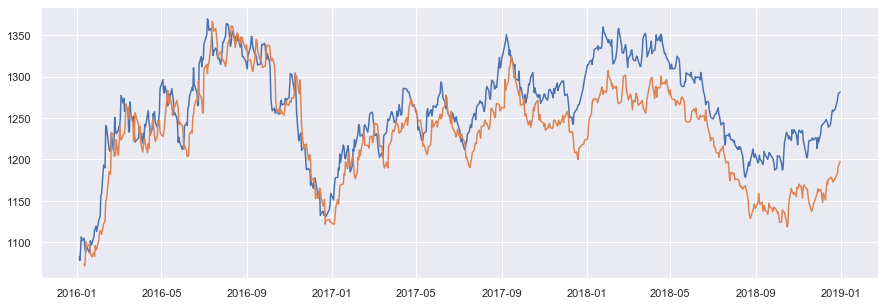

In [128]:
plt.plot(GP_df.loc[test_set_def, 'Date'], GP_df.loc[test_set_def, 'Gold'])
ypred = pd.DataFrame(fit8.predict(x_test8)).shift(periods = 5)
plt.plot(GP_df.loc[test_set_def, 'Date'], ypred)

# --- Plot of actial gold price in blue and prdic
#


Validation R^2 score was: 0.4772345221908769
Feature coefficient results: 

Gold : 0.80146225
GoldFutures : 0.16085639
Silver : 1.19851024
Platinum : 0.00403397
Palladium : -0.02031784
OilSpot : -0.21919338
SP500 : -0.02419034
DJI : -0.00253736
FTSE : 0.01887729
TBill : -6.64778762
FedFundRates : -1.69900822
USDX : -0.20356726


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             Gold_1week   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          4.896e+05
Date:                Sun, 06 Oct 2019   Prob (F-statistic):                        0.00
Time:                        08:48:32   Log-Likelihood:                         -18274.
No. Observations:                3934   AIC:                                  3.657e+04
Df Residuals:                    3922   BIC:                                  3.665e+04
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Gold             0.8034      0.019     41.700      0.000       0.766       0.841
GoldFutures      0.1651      0.018      9.094      0.000       0.130       0.201
Silver           1.1455      0.206      5.550      0.000       0.741       1.550
Platinum         0.0086      0.003      2.477      0.013       0.002       0.015
Palladium       -0.0280      0.004     -7.041      0.000      -0.036      -0.020
OilSpot         -0.2036      0.044     -4.633      0.000      -0.290      -0.117
SP500           -0.0244      0.011     -2.260      0.024      -0.046      -0.003
DJI             -0.0020      0.001     -1.501      0.133      -0.005       0.001
FTSE             0.0179      0.002      8.153      0.000       0.014       0.022
TBill           -5.0601      1.175     -4.307      0.000      -7.364      -2.757
FedFundRates    -1.6264      0.562     -2.892      0.004      -2.729      -0.524
USDX             0.0473      0.054      0.878      0.380      -0.058       0.153
==============================================================================
Omnibus:                      776.563   Durbin-Watson:                   0.439
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10832.127
Skew:                          -0.533   Prob(JB):                         0.00
Kurtosis:                      11.059   Cond. No.                     3.98e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.98e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

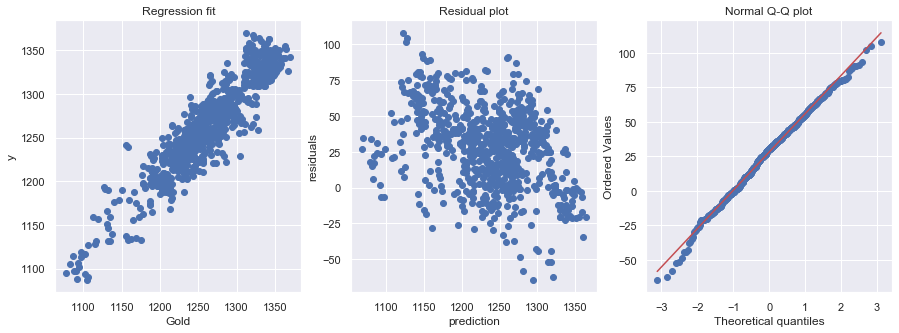

In [116]:
vars2 = ['Gold', 'GoldFutures','Silver', 'Platinum', 'Palladium', 'OilSpot', \
            'SP500', 'DJI', 'FTSE', 'TBill', 'FedFundRates', 'USDX', \
            ]

x_train9 = GP_df.loc[train_set_def, vars2].copy()
y_train9 = GP_df.loc[train_set_def, 'Gold_1week'].copy()

x_test9 = GP_df.loc[test_set_def, vars2].copy()
y_test9 = GP_df.loc[test_set_def, 'Gold_1week'].copy()

linear_wCoefs(x_train9, y_train9, x_test9, y_test9)

model9 = sm.OLS(y_train9, x_train9)
fit9 = model9.fit()
fit9.summary()



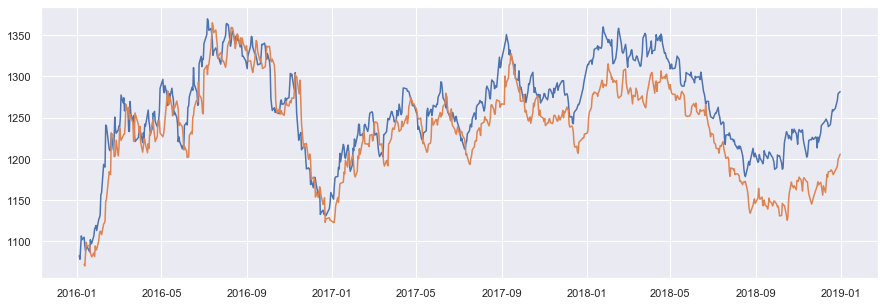

In [129]:
plt.plot(GP_df.loc[test_set_def, 'Date'], GP_df.loc[test_set_def, 'Gold'])
ypred = pd.DataFrame(fit9.predict(x_test9)).shift(periods = 5)
plt.plot(GP_df.loc[test_set_def, 'Date'], ypred)

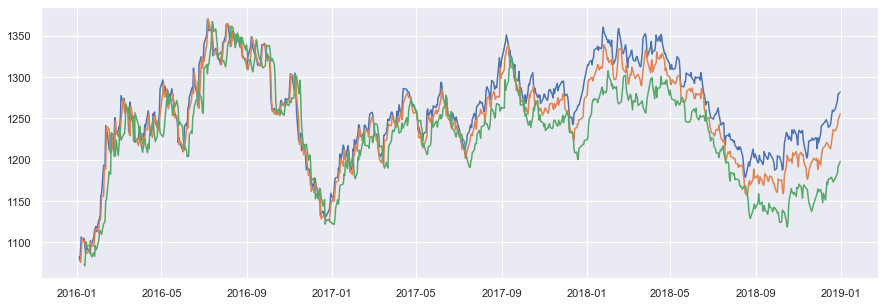

In [130]:
plt.plot(GP_df.loc[test_set_def, 'Date'], GP_df.loc[test_set_def, 'Gold'])

# Next day forecast (without SP500) R2 = 0.89
ypred = pd.DataFrame(fit7.predict(x_test7)).shift(periods = 1)
plt.plot(GP_df.loc[test_set_def, 'Date'], ypred)

# Next week forecast (without SP500) R2 = 0.38
ypred2 = pd.DataFrame(fit8.predict(x_test8)).shift(periods = 5)
plt.plot(GP_df.loc[test_set_def, 'Date'], ypred2)


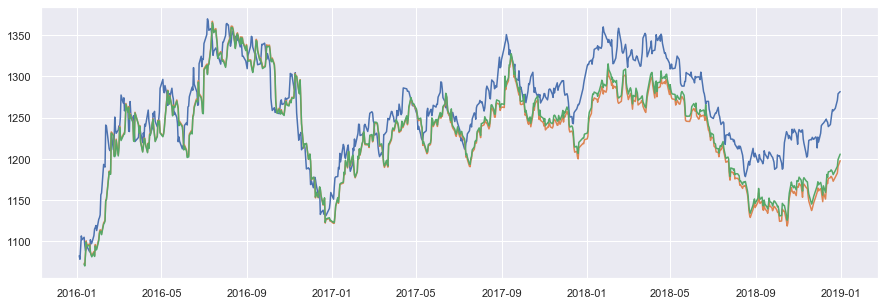

In [131]:
plt.plot(GP_df.loc[test_set_def, 'Date'], GP_df.loc[test_set_def, 'Gold'])

# Next week forecast (without SP500) R2 = 0.38
ypred2 = pd.DataFrame(fit8.predict(x_test8)).shift(periods = 5)
plt.plot(GP_df.loc[test_set_def, 'Date'], ypred2)

# Next week forecast (WITH SP500) R2 = 0.48
ypred3 = pd.DataFrame(fit9.predict(x_test9)).shift(periods = 5)
plt.plot(GP_df.loc[test_set_def, 'Date'], ypred3)


Validation R^2 score was: 0.7179322878045514
Feature coefficient results: 

Gold : 0.87719535
GoldFutures : 0.10550015
Silver : 0.40239623
SP500 : -0.02462744
FTSE : 0.00759643
FedFundRates : -1.39863340
USDX : -0.14221964


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             Gold_1week   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          8.243e+05
Date:                Sun, 06 Oct 2019   Prob (F-statistic):                        0.00
Time:                        19:48:11   Log-Likelihood:                         -18313.
No. Observations:                3934   AIC:                                  3.664e+04
Df Residuals:                    3927   BIC:                                  3.668e+04
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Gold             0.8867      0.016     56.017      0.000       0.856       0.918
GoldFutures      0.0975      0.016      6.248      0.000       0.067       0.128
Silver           0.3591      0.174      2.067      0.039       0.018       0.700
SP500           -0.0277      0.003     -8.148      0.000      -0.034      -0.021
FTSE             0.0095      0.001      6.380      0.000       0.007       0.012
FedFundRates    -1.6842      0.504     -3.341      0.001      -2.673      -0.696
USDX            -0.0551      0.033     -1.645      0.100      -0.121       0.011
==============================================================================
Omnibus:                      811.564   Durbin-Watson:                   0.441
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10989.826
Skew:                          -0.591   Prob(JB):                         0.00
Kurtosis:                      11.102   Cond. No.                     7.40e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.4e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

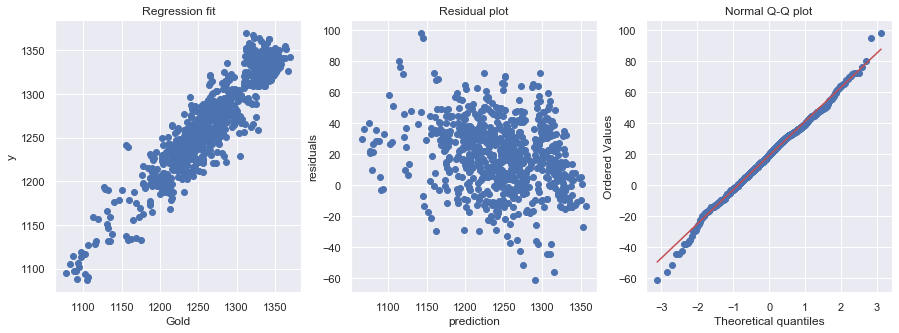

In [134]:
# --- How to reduce multicolinearity as indicated by the high condition number? Remove Platinum and Palladium?
vars4 = ['Gold', 'GoldFutures','Silver', \
        'SP500', 'FTSE', 'FedFundRates', 'USDX', \
        ]

x_train10 = GP_df.loc[train_set_def, vars4].copy()
y_train10 = GP_df.loc[train_set_def, 'Gold_1week'].copy()

x_test10 = GP_df.loc[test_set_def, vars4].copy()
y_test10 = GP_df.loc[test_set_def, 'Gold_1week'].copy()

linear_wCoefs(x_train10, y_train10, x_test10, y_test10)

model10 = sm.OLS(y_train10, x_train10)
fit10 = model10.fit()
fit10.summary()




Validation R^2 score was: 0.9532555444074641
Feature coefficient results: 

Gold : 0.89262711
GoldFutures : 0.10471712
Silver : 0.21143322
SP500 : -0.00866586
FedFundRates : 0.65435622
USDX : -0.00485661


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              Gold_next   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          4.397e+06
Date:                Sun, 06 Oct 2019   Prob (F-statistic):                        0.00
Time:                        19:52:57   Log-Likelihood:                         -15322.
No. Observations:                3934   AIC:                                  3.066e+04
Df Residuals:                    3928   BIC:                                  3.069e+04
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Gold             0.8976      0.007    121.626      0.000       0.883       0.912
GoldFutures      0.1018      0.007     14.156      0.000       0.088       0.116
Silver           0.2050      0.080      2.552      0.011       0.048       0.363
SP500           -0.0085      0.001     -8.576      0.000      -0.010      -0.007
FedFundRates     0.7765      0.154      5.031      0.000       0.474       1.079
USDX             0.0697      0.009      7.514      0.000       0.052       0.088
==============================================================================
Omnibus:                     1433.881   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           565356.595
Skew:                          -0.286   Prob(JB):                         0.00
Kurtosis:                      61.726   Cond. No.                     1.60e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.6e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

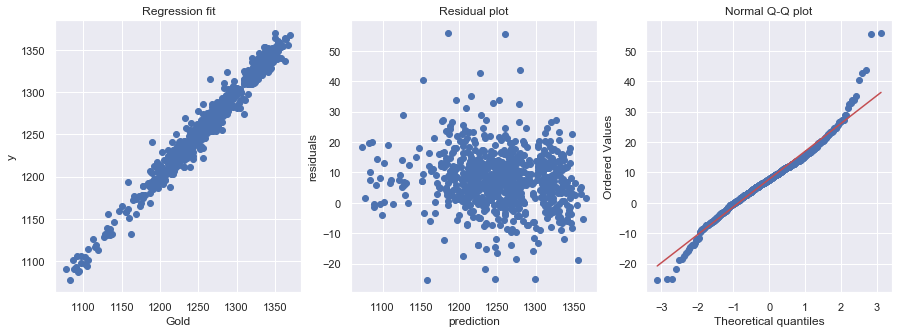

In [140]:
# --- How to reduce multicolinearity as indicated by the high condition number? Remove Platinum and Palladium?
vars5 = ['Gold', 'GoldFutures','Silver', \
        'SP500', 'FedFundRates', 'USDX', \
        ]

x_train11 = GP_df.loc[train_set_def, vars5].copy()
y_train11 = GP_df.loc[train_set_def, 'Gold_next'].copy()

x_test11 = GP_df.loc[test_set_def, vars5].copy()
y_test11 = GP_df.loc[test_set_def, 'Gold_next'].copy()

linear_wCoefs(x_train11, y_train11, x_test11, y_test11)

model11 = sm.OLS(y_train11, x_train11)
fit11 = model11.fit()
fit11.summary()

